# IRWA Final Project
## **Part 3- Ranking**

Authors:


*   Malena Díaz - u172961
*   Cristina Galvez - u172954






In [1]:
data_path = 'drive/Shareddrives/IRWA/Project/data/tw_hurricane_data.json'
map_path = 'drive/Shareddrives/IRWA/Project/data/tweet_document_ids_map.csv'

In [2]:
!pip install word2number

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for word2number: filename=word2number-1.1-py3-none-any.whl size=5582 sha256=f2c16c1f747395d2bf91fef4364d8cd41521b622dac2595b0b04981cccec06f8
  Stored in directory: /root/.cache/pip/wheels/4b/c3/77/a5f48aeb0d3efb7cd5ad61cbd3da30bbf9ffc9662b07c9f879
Successfully built word2number


In [3]:
import json
import string
import re
import csv
from word2number import w2n
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import datetime
from array import array
import math
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from collections import defaultdict
from numpy import linalg as la
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Preprocessing




In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data_path
with open(data_path) as fp:
    data = fp.readlines()

In [6]:
#importing the map id => document name 
doc_id_dict = {}
with open(map_path) as map_file:
    tsv_reader = csv.reader(map_file, delimiter="\t")
    for line in tsv_reader:
      (doc, id) = line
      doc_id_dict[int(id)] = doc

In [7]:
print("Total number of Tweets in the dataset: {}".format(len(data)))
print("Total number of Tweets in the map: {}".format(len(doc_id_dict)))

Total number of Tweets in the dataset: 4000
Total number of Tweets in the map: 4000


In [8]:
data = [json.loads(x) for x in data] # transform each tweet from string to dictionnary 

In [9]:
def create_struct(data):
  """
  Extract the fields tweet, username, date, hashtag, number of likes, the number of retweets and the tweet url from each tweet. 
  
  Argument:
  data -- An array of tweets (dictionnaries) that contain the keys full_text, user, created_at, entities and retweet_count. User and entities 
  correspond both to dictionnaries containing keys screen_name and favourites_count respectively. 

  Returns:
  collection -- A collection of dictionnaries where the key corresponds to the dictionnary name. Each value is another dictionnary containing the fields 
  of interest. 

  """
  collection = {}     # dictionary of dictionaries

  for tweet in data:
    doc_dict = {}
    id = tweet['id']
    doc_name = doc_id_dict[id]

    doc_dict['id'] = id
    doc_dict['tweet'] = tweet['full_text']
    doc_dict['username'] = tweet['user']['screen_name']
    doc_dict['date'] = datetime.datetime.strptime(tweet['created_at'], '%a %b %d %H:%M:%S %z %Y') #convert to date time 
    doc_dict['hashtag'] = [x['text'] for x in tweet['entities']['hashtags']] #text of te hashtag 
    doc_dict['likes'] = tweet['user']['favourites_count']
    doc_dict['retweet'] = tweet ['retweet_count'] # can also be field retweeted (true)
    doc_dict['url'] = "https://twitter.com/" +  doc_dict['username'] + "/status/" + str(id) #https://twitter.com/[screen name]/status/[Tweet ID]
    collection[doc_name] = doc_dict

  return collection

In [10]:
# to handle turning written numbers into digits

def is_written_num(word):
  # returns True only if it is a written number
  # returns False if it is a digit or something else
  try:
    w2n.word_to_num(word)
    try: 
      int(word)
      return False
    except:
      return True
  except:
    return False

# given an array of strings, takes all written numbers and makes them digits
def make_numbers_digits(text):
  consec_num = False
  num_string = ''
  result = []

  for word in text:
    if not is_written_num(word):
      if consec_num:
        result.append(str(w2n.word_to_num(num_string)))
        consec_num = False
        num_string = ''
      result.append(word)
    else:
      consec_num = True
      num_string += ' ' + word

  if consec_num:
    result.append(str(w2n.word_to_num(num_string)))

  return result

In [11]:
def treat_hashtags(text):
  remove_hashtag = text[1:]
  split_lower_upper = re.sub(r"([A-Z])", r" \1", remove_hashtag)
  return split_lower_upper

In [12]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    # define stemmer and reference lists
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    whitelist = string.ascii_letters + string.digits + ' '

    # clean text
    line = re.sub(r'http\S+', '', line) # remove urls
    line = re.sub(r'@\S+', '', line) # remove mentioned users
    line = ' '.join([treat_hashtags(i) if i.startswith("#") else i for i in line.split()]) # deal with hashtags
    line = line.replace("-", " ") # deal with dashes
    line = line.replace("$", " dollars") # deal with currencies  
    line = line.replace("€", " euros") # deal with currencies  
    line = ''.join([char if char in whitelist else ' ' for char in line]) # remove all symbols (leave only letters, digits, # and spaces)
    line = line.lower() ## Transform in lowercase
    line = line.split() ## Tokenize the text to get a list of terms
    line = [x for x in line if x not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line = [stemmer.stem(x) for x in line ] ## perform stemming (HINT: use List Comprehension)
    line = make_numbers_digits(line) # turn written numbers into digits
    line = [x for x in line if (len(x) > 1 or x.isdigit()) ] # remove single letters

    return line

In [13]:
data = create_struct(data)  # transform data


### Index creation

To create the index we use the same function as in other labs but with a few modifications. Now the function returns also:


*   dl: dictionnary containing for each doc_id (key) the length of that doc (value)
*   adl: float that informs about the average document length of the collection



In [14]:
def create_index_tfidf(collection, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    collection -- collection of tweets 
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    dl - dict with the length (counting only index terms) of each doc  
    adl - float with the average document length of the collection
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    dl = defaultdict(int)
    title_index = defaultdict(str)
    idf = defaultdict(float)

    for key in collection:
        doc = collection[key]
        title_index[key] = doc['id']
        terms = build_terms(doc['tweet']) #retrieves a dict 
        dl[key] = len(terms)

        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position) # term already added in doc array 
            except:
                current_page_index[term]=[key, [position]]

        #normalize term frequencies
        #norm is the square root of the sum of the frequency of each term squared
        norm = 0
        for term, posting in current_page_index.items():
            norm += len(posting[1]) ** 2 #len(posting[1]) == number of times it appears in the doc (frecuency of a term)
        norm = math.sqrt(norm) 

        # compute the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            tf[term].append(np.round(len(posting[1])/norm,4)) #tf is frecuency of the term / norm
            df[term] = df[term] + 1 # df is number of documents where that doc appears (we increment it by one)

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page) #for each term add this doc and its position to the general index

        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4) #idf of the term is log ( num_docs / df [term])
    
    #compute the avg doc length
    adl = sum(dl.values()) / len(dl)

    return index, tf, df, dl, adl, idf, title_index


In [15]:
start_time = time.time()
num_documents = len(data)
index, tf, df_,  dl, adl, idf, title_index = create_index_tfidf(data, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 206.69 seconds


### Ranking Algorithm: TF-IDF vector representation + cosine similarity


In [16]:
def tf_idf_cos_score(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    A list of the doc_ids sorted from the one with highest similarity to the one with lowest similarity. 
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # for each doc we have a dict where the key is each term of the query term and the value its score
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    query_norm = la.norm(list(query_terms_count.values())) #normalize it 

    for termIndex, term in enumerate(terms):  #for each term in the query 
        if term not in index: #if term is not in index go to the next term 
            continue

        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]  #tf of the term * idf term 

        # Generate doc_vectors. For each doc & each term we have a score 
        for doc_index, (doc, postings) in enumerate(index[term]): #for each document containing that term 

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs: 
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  #take the tf in that doc and multiply it by the idf 

    #compute cosine similarity between query_vector & the doc_vecotr 
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ] 
    doc_scores.sort(reverse=True)  
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = rank_tf_idf_cos(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs

In [17]:
def select_docs_query (query, index):
    """
    Given a query string (without pre-processing), select the documents that contain all index terms of the query
    
    Argument:
    query -- the query as the raw un-pre-processed string 
    index -- inverted index data structure
    
    Returns:
    List of doc_ids that contain all index terms of the query 
    """
    query = build_terms(query) #pre-process the string 
    docs =  set()
    first_time = True

    for term in query: #take a list of all documents that contain all the terms
        try:
            # store in term_docs the ids of the docs that contain the term                       
            term_docs=[posting[0] for posting in index[term]]
            if first_time: #first term
                docs = docs.union(set(term_docs))
                first_time = False
            else:
                docs = docs.intersection(set(term_docs))
        except:
            #term is not in index
            pass

    docs = list(docs)
    return query, docs

In [18]:
def rank_tf_idf_cos(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query, docs = select_docs_query(query,index)
    ranked_docs = tf_idf_cos_score(query, docs, index, idf, tf, title_index)
    return ranked_docs

### Our score + Cosine Similarity

Our score is based on popularity, which takes into account:

*   Amount of **likes** for document
*   Amount of **retweets** for document
*   Amount of **hastags** for document 

Each of the variables takes the logarithm and is normalized using min-max normalization. The final score has the following shape:

$$popularity\ score  = \frac{1}{2}(like\ score + retweet\ score) + hashtag\ score$$

In [19]:
# get data for document
retweets = {}
likes = {}
hashtags = {}

for i in data:
  retweets[i] = data[i]['retweet']
  likes[i] = data[i]['likes']
  hashtags[i] = len(data[i]['hashtag'])

In [20]:
def distribution_plot(data):
  fig, ax = plt.subplots(1,2, figsize=(15, 6))
  sns.histplot(data=data, bins=100, ax=ax[0])
  sns.boxplot(data=data, ax=ax[1])
  plt.show()

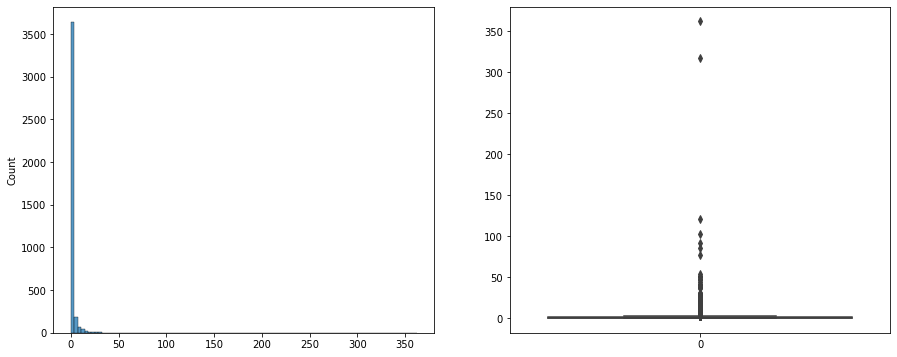

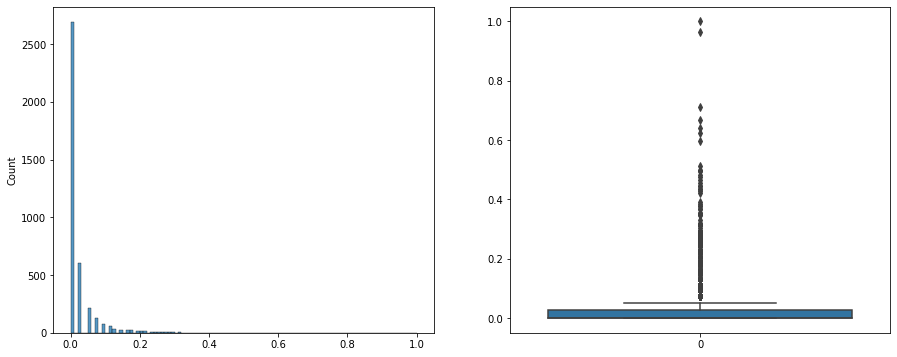

In [21]:
# retweet data, take logarithm and normalize
# plot before and after
retweetlog = [np.log(i + 10) for i in retweets.values()]
retweetlog_n = [(i - min(retweetlog))/(max(retweetlog) - min(retweetlog)) for i in retweetlog]
distribution_plot(list(retweets.values()))
distribution_plot(retweetlog_n)

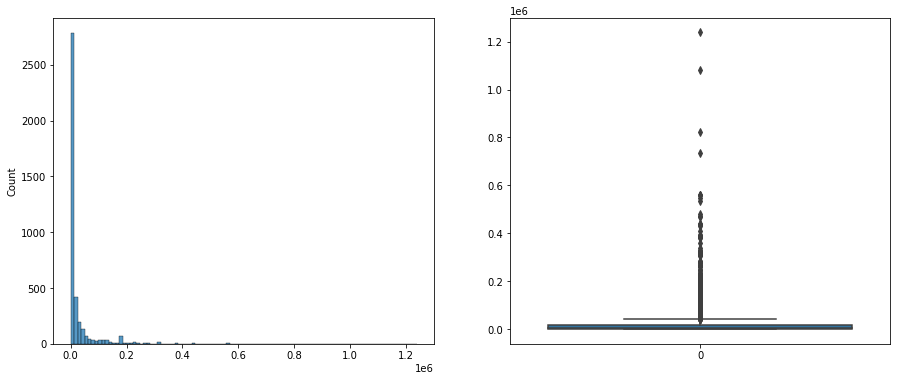

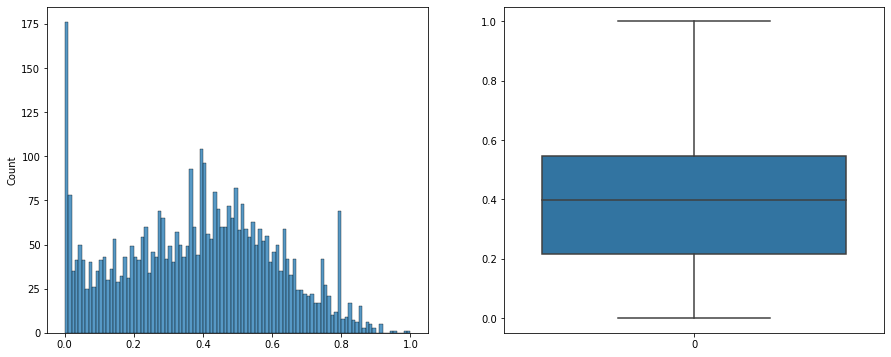

In [22]:
# likes data, take logarithm and normalize
# plot before and after
likelog = [np.log(i + 100) - np.log(100) for i in likes.values()]
likelog_n = [(i - min(likelog))/(max(likelog) - min(likelog)) for i in likelog]
distribution_plot(list(likes.values()))
distribution_plot(likelog_n)

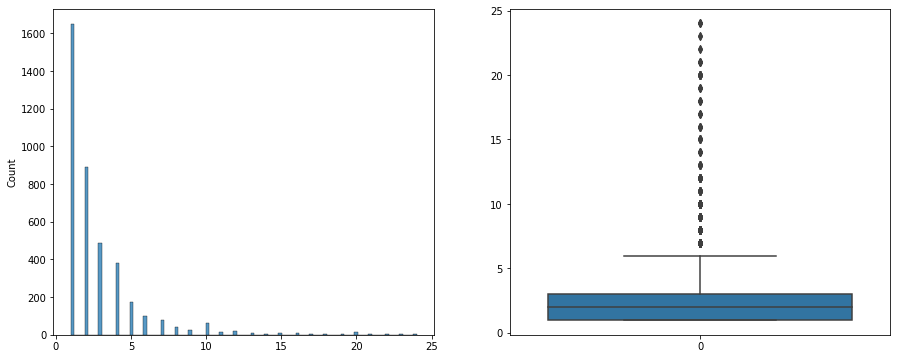

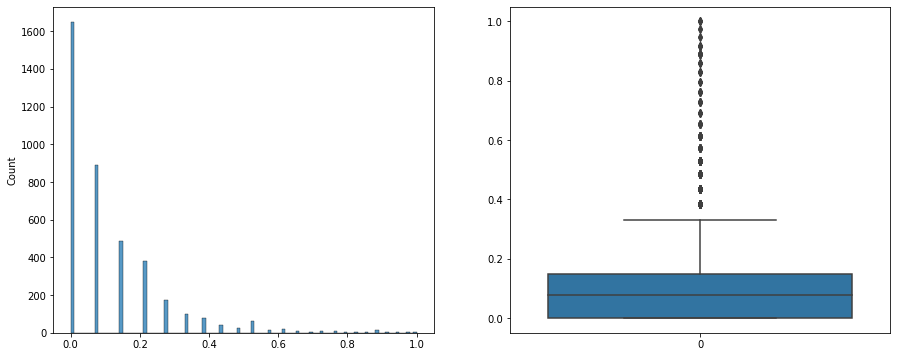

In [23]:
# hashtag data, take logarithm and normalize
# plot before and after
hashtag_sc = [np.log(i + 10) - np.log(10) for i in hashtags.values()]
hashtag_n = [(i - min(hashtag_sc))/(max(hashtag_sc) - min(hashtag_sc)) for i in hashtag_sc]
distribution_plot(list(hashtags.values()))
distribution_plot(hashtag_n)

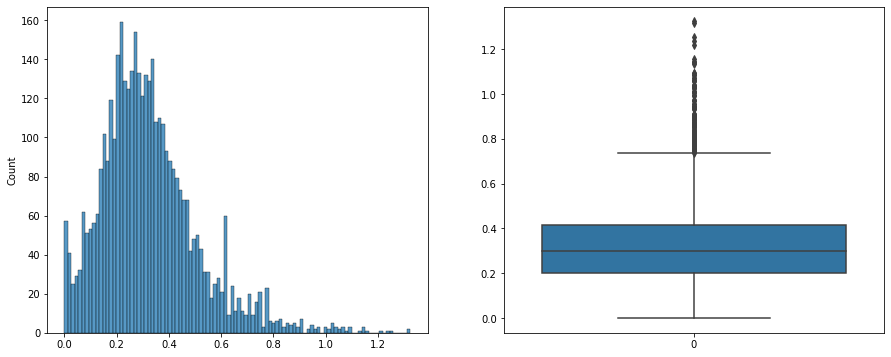

In [24]:
# sum scores
our_score = [(a + b) / 2 + c for (a, b, c) in zip(retweetlog_n, likelog_n, hashtag_n)]
distribution_plot(our_score)

# create dictiorary with popularity score for each document (does not depend on query)
popularity_score = {doc_id : our_score[i] for i, doc_id in zip(range(len(data)), data)}

In [25]:
def rank_ourScore_cos(terms, docs, index, idf, tf, title_index, pop_score, w):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    pop_score -- dictionary of popularity scores per document
    w -- weight for the popularity score term
    
    Returns:
    A list of the doc_ids sorted from the one with highest similarity to the one with lowest similarity. 
    """
    doc_vectors = defaultdict(lambda: [0] * len(terms))
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):
        if term not in index: #if term is not in index go to the next term 
            continue

        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]  #tf of the term * idf term 

        # Generate doc_vectors. For each doc & each term we have a score 
        for doc_index, (doc, postings) in enumerate(index[term]): 
         
            if doc in docs: 
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  

    # compute cosine similarity between query_vector & the doc_vecotr and ADD POPULARITY SCORE with weight w
    doc_scores = [[np.dot(curDocVec, query_vector)  + w * pop_score[doc] , doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)  
    result_docs = [x[1] for x in doc_scores]

    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = rank_tf_idf_cos(query, index)

    return result_docs

In [26]:
def rank_our_score(query, index, w=0.5):
    query, docs = select_docs_query(query, index)
    ranked_docs = rank_ourScore_cos(query, docs, index, idf, tf, title_index, popularity_score, w)
    return ranked_docs

In [27]:
# test new ranking metric
print("Insert your query (i.e.: Landfall in South Carolina):\n")
query = input()
ranked_docs = rank_our_score(query, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("page_id= {} - page_title: {}".format(d_id, title_index[d_id]))
    print("tweet: {} \n\n".format(data[d_id]['tweet']))

Insert your query (i.e.: Landfall in South Carolina):

Landfall in South Carolina

Top 10 results out of 101 for the searched query:

page_id= doc_249 - page_title: 1575914959091163136
tweet: #HurricaneIan makes landfall in South Carolina... https://t.co/vKik1OyOgQ 


page_id= doc_2505 - page_title: 1575875671385071618
tweet: ⚠️ #HurricaneIan about to make landfall on South Carolina! https://t.co/X61NAwpsx6 


page_id= doc_255 - page_title: 1575914903806042112
tweet: #BREAKING | #HurricaneIan makes landfall in US' South Carolina https://t.co/T8f7Gq5jnb 


page_id= doc_1492 - page_title: 1575896918441369600
tweet: #HurricaneIan is now making #landfall into #SouthCarolina Coastline! https://t.co/yoTfc6Hr5U 


page_id= doc_345 - page_title: 1575913904143626240
tweet: NEW: #HurricaneIan has made landfall once again, this time in South Carolina: https://t.co/vIAw3QjFwn 


page_id= doc_814 - page_title: 1575908545362640906
tweet: 🌀 @NBCNews Special Report: #HurricaneIan making landfall in #S

In [28]:
# compare cosine sim vs our score
query = 'Landfall in South Carolina'
ranked_docs_cos = rank_tf_idf_cos(query, index)
ranked_docs_ourscore = rank_our_score(query, index, w=0.8)
top = 10
docs_in_common = 0

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs_cos)))
for i in range(min(top, len(ranked_docs_cos))):
  print("Cosine sim: {:>8}, Our score doc_id: {:>8} Popularity score: {:>6.3f}".format(ranked_docs_cos[i], ranked_docs_ourscore[i], popularity_score[ranked_docs_ourscore[i]]))
  if ranked_docs_ourscore[i] in ranked_docs_cos[:top]:
      docs_in_common +=1 
print("\n\nThe two ranking algorithms outputted {} rankings in common out of {}. ({}%)".format(docs_in_common, top, docs_in_common*100/min(top, len(ranked_docs_cos))))


Top 10 results out of 101 for the searched query:

Cosine sim: doc_2505, Our score doc_id:  doc_249 Popularity score:  0.278
Cosine sim:  doc_249, Our score doc_id: doc_2505 Popularity score:  0.025
Cosine sim:  doc_255, Our score doc_id:  doc_255 Popularity score:  0.318
Cosine sim: doc_1492, Our score doc_id: doc_1492 Popularity score:  0.222
Cosine sim:  doc_814, Our score doc_id:  doc_231 Popularity score:  0.546
Cosine sim:  doc_345, Our score doc_id:  doc_345 Popularity score:  0.223
Cosine sim: doc_1444, Our score doc_id:  doc_814 Popularity score:  0.193
Cosine sim: doc_1536, Our score doc_id: doc_1444 Popularity score:  0.299
Cosine sim:  doc_682, Our score doc_id: doc_1335 Popularity score:  0.584
Cosine sim:  doc_231, Our score doc_id: doc_1536 Popularity score:  0.302


The two ranking algorithms outputted 9 rankings in common out of 10. (90.0%)


### Ranking Algorithm: BM25

To use implement the BM25 ranking algorithm we will use two functions in a very similar way we did with the vector representation + cosine similarity algorithm. <br>

In [29]:
def bm25_score (terms, docs, index, idf, tf, title_index, dl, adl, k1 = 1.4 , b = 0.75):
   """
    Perform the ranking of the results of a search based on bm25 algorithm
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    dl - dict with the length (counting only index terms) of each doc  
    adl - float with the average document length of the collection
    k1 - parameter of the BM25 formula set to 1.4 by default 
    b - parameter of the BM25 formula set to 0.75 by default 
    
    Returns:
    A list of the doc_ids sorted from the one with highest BM25 score to the lowest.  
   """
   
   bm25_score = 0
   results = defaultdict(lambda:0) # for each doc we have a dict where the key is each term of the query term and the value its score

   for termIndex, term in enumerate(terms):  #for each term in the query 
        if term not in index: #if term is not in index go to the next term 
            continue

        for doc_index, (doc, postings) in enumerate(index[term]): #for each document containing that term 
            if doc in docs: 
                len_norm = (1-b) + b * (dl[doc] / adl)
                num = (k1 + 1) * tf[term][doc_index]
                denom = tf[term][doc_index] + k1 * len_norm
                results[doc] += (num/denom) * idf[term]  #take the tf in that doc and multiply it by the idf 
   
   if len(results) == 0: #if we did not find any docs 
      print("No results found, try again")
      query = input()
      docs = rank_bm25(query, index)

   sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse = True)) #sort the results 
   result_docs = sorted_results.keys()
   return list(result_docs)

In [30]:
def rank_bm25(query, index):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query, docs = select_docs_query(query,index)
    ranked_docs = bm25_score(query, docs, index, idf, tf, title_index, dl, adl)
    return ranked_docs

In [31]:
print("Insert your query (i.e.: Landfall in South Carolina):\n")
query = input()
ranked_docs = rank_bm25(query, index)
top = 10

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("page_id= {} - page_title: {}".format(d_id, title_index[d_id]))
    print("tweet: {} \n\n".format(data[d_id]['tweet']))

Insert your query (i.e.: Landfall in South Carolina):

Landfall in South Carolina

Top 10 results out of 101 for the searched query:

page_id= doc_249 - page_title: 1575914959091163136
tweet: #HurricaneIan makes landfall in South Carolina... https://t.co/vKik1OyOgQ 


page_id= doc_2505 - page_title: 1575875671385071618
tweet: ⚠️ #HurricaneIan about to make landfall on South Carolina! https://t.co/X61NAwpsx6 


page_id= doc_255 - page_title: 1575914903806042112
tweet: #BREAKING | #HurricaneIan makes landfall in US' South Carolina https://t.co/T8f7Gq5jnb 


page_id= doc_1492 - page_title: 1575896918441369600
tweet: #HurricaneIan is now making #landfall into #SouthCarolina Coastline! https://t.co/yoTfc6Hr5U 


page_id= doc_345 - page_title: 1575913904143626240
tweet: NEW: #HurricaneIan has made landfall once again, this time in South Carolina: https://t.co/vIAw3QjFwn 


page_id= doc_814 - page_title: 1575908545362640906
tweet: 🌀 @NBCNews Special Report: #HurricaneIan making landfall in #S

We use the following cells to compare between the BM25 ranking and the tf-idf wwights + cosine similarity ranking method. 

In [32]:
# compare cosine sim vs bm25
print("Insert your query (i.e.: Landfall in South Carolina):\n")
query = input()
ranked_docs_cos = rank_tf_idf_cos(query, index)
ranked_docs_bm25 = rank_bm25(query, index)
top = 10
docs_in_common = 0

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs_cos)))
for i in range(top):
    print("Cosine sim: doc_id= {}, BM25 doc_id: {}".format(ranked_docs_cos[i], ranked_docs_bm25[i]))
    if ranked_docs_bm25[i] in ranked_docs_cos[:top]:
      docs_in_common +=1 
print("\n\nThe two ranking algorithms outputted {} rankings in common out of {}. ({}%)".format(docs_in_common, top, docs_in_common*100/top))

Insert your query (i.e.: Landfall in South Carolina):

Landfall in South Carolina

Top 10 results out of 101 for the searched query:

Cosine sim: doc_id= doc_2505, BM25 doc_id: doc_249
Cosine sim: doc_id= doc_249, BM25 doc_id: doc_2505
Cosine sim: doc_id= doc_255, BM25 doc_id: doc_255
Cosine sim: doc_id= doc_1492, BM25 doc_id: doc_1492
Cosine sim: doc_id= doc_814, BM25 doc_id: doc_345
Cosine sim: doc_id= doc_345, BM25 doc_id: doc_814
Cosine sim: doc_id= doc_1444, BM25 doc_id: doc_231
Cosine sim: doc_id= doc_1536, BM25 doc_id: doc_682
Cosine sim: doc_id= doc_682, BM25 doc_id: doc_636
Cosine sim: doc_id= doc_231, BM25 doc_id: doc_9


The two ranking algorithms outputted 8 rankings in common out of 10. (80.0%)


In [33]:
print(data['doc_2505']['tweet'], '(characters: ', len(data['doc_2505']['tweet']), ')')
print(data['doc_249']['tweet'], '(characters: ', len(data['doc_249']['tweet']), ')')

⚠️ #HurricaneIan about to make landfall on South Carolina! https://t.co/X61NAwpsx6 (characters:  82 )
#HurricaneIan makes landfall in South Carolina... https://t.co/vKik1OyOgQ (characters:  73 )


### Word2vec + cosine similarity

We first train the model using the collection. In order to do that we pass as the argument sentences, the index terms of each document. 

In [34]:
#data preparation
training_data = []
tweets_built_terms = defaultdict()

for doc_id in data:
  tweet = data[doc_id]['tweet']
  tweet_index_terms = build_terms(tweet)
  training_data.append(tweet_index_terms)# we will use this to trian the model
  tweets_built_terms[doc_id] = tweet_index_terms #we will use this later 


In [35]:
vector_size = 300

model = Word2Vec(sentences=training_data, size=vector_size, window=5, min_count=1, workers=4)

We define a function tweet2vec that transforms a list of terms (or a string) to a vector representation using word2vec. 

In [36]:
def tweet2vec (terms):
  """
  Converts a list of index terms (or a string) into a vector using the word2vec model 

  Arguments:
  terms: a list of terms or a string 

  Returns:
  A vectorsize-dimensional vector representing the tweet
  """
  total = [0] * vector_size
  n_terms = len(terms)

  for i in terms:
    word2vec = model.wv[i] # represent the word as a vector 
    total = [ total[x] + word2vec[x] for x in range(vector_size)] #sum each dimension
 
  tweetVec = [x/n_terms for x in total] #take avg across terms 

  return tweetVec

Now we are prepared to rank the documents. 

In [37]:
def word2vec_cos_score(terms, docs, collection ):
    """
    """
    query_vector = tweet2vec(terms)
    doc_vectors = defaultdict() # dictionnary of docs 

    for doc in docs:
      doc_vectors[doc] = tweet2vec(collection[doc]) #cmpute twee2vec representation

    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ] #cosine similarity
    doc_scores.sort(reverse=True)  
    result_docs = [x[1] for x in doc_scores]
    return result_docs
    

In [38]:
def rank_word2vec_cos(query, collection):
    """
    output is the list of documents that contain any of the query terms. 
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query, docs = select_docs_query(query,index) #select docs with query terms (intersection)
    ranked_docs = word2vec_cos_score(query, docs, collection)
    return ranked_docs

In [39]:
print("Insert your query (i.e.: Landfall in South Carolina):\n")
query = input()
ranked_docs = rank_word2vec_cos(query, tweets_built_terms)
top = 20

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("page_id= {} - page_title: {}".format(d_id, title_index[d_id]))
    print("tweet: {} \n\n".format(data[d_id]['tweet']))

Insert your query (i.e.: Landfall in South Carolina):

Landfall in South Carolina

Top 20 results out of 101 for the searched query:

page_id= doc_255 - page_title: 1575914903806042112
tweet: #BREAKING | #HurricaneIan makes landfall in US' South Carolina https://t.co/T8f7Gq5jnb 


page_id= doc_2505 - page_title: 1575875671385071618
tweet: ⚠️ #HurricaneIan about to make landfall on South Carolina! https://t.co/X61NAwpsx6 


page_id= doc_249 - page_title: 1575914959091163136
tweet: #HurricaneIan makes landfall in South Carolina... https://t.co/vKik1OyOgQ 


page_id= doc_2356 - page_title: 1575877945633013761
tweet: New rule.  If you are a hurricane, you only get one landfall.   😡😬😢 #Hurricane #hurricaneian #SouthCarolina 


page_id= doc_2918 - page_title: 1575870287056248833
tweet: Hurricane Ian begins to make landfall in South Carolina https://t.co/4tMbjEiAJ5 #HurricaneIan 


page_id= doc_636 - page_title: 1575910357293764608
tweet: #HurricaneIan about to make landfall in South Carolina

Compare word2vec vs tf-idf + cosine similarity

In [40]:
# compare cosine sim vs bm25
print("Insert your query (i.e.: Landfall in South Carolina):\n")
query = input()
ranked_docs_cos = rank_tf_idf_cos(query, index)
ranked_docs_w2v = rank_word2vec_cos(query, tweets_built_terms)
top = 10
docs_in_common = 0

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs_cos)))
for i in range(top):
    print("Cosine sim: doc_id= {}, Word2Vec doc_id: {}".format(ranked_docs_cos[i], ranked_docs_w2v[i]))
    if ranked_docs_w2v[i] in ranked_docs_cos[:top]:
      docs_in_common +=1 
print("\n\nThe two ranking algorithms outputted {} rankings in common out of {}. ({}%)".format(docs_in_common, top, docs_in_common*100/top))

Insert your query (i.e.: Landfall in South Carolina):

Landfall in South Carolina

Top 10 results out of 101 for the searched query:

Cosine sim: doc_id= doc_2505, Word2Vec doc_id: doc_255
Cosine sim: doc_id= doc_249, Word2Vec doc_id: doc_2505
Cosine sim: doc_id= doc_255, Word2Vec doc_id: doc_249
Cosine sim: doc_id= doc_1492, Word2Vec doc_id: doc_2356
Cosine sim: doc_id= doc_814, Word2Vec doc_id: doc_2918
Cosine sim: doc_id= doc_345, Word2Vec doc_id: doc_636
Cosine sim: doc_id= doc_1444, Word2Vec doc_id: doc_345
Cosine sim: doc_id= doc_1536, Word2Vec doc_id: doc_171
Cosine sim: doc_id= doc_682, Word2Vec doc_id: doc_25
Cosine sim: doc_id= doc_231, Word2Vec doc_id: doc_231


The two ranking algorithms outputted 5 rankings in common out of 10. (50.0%)
